# Question 1
# Implement GMM without any builtin functions

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\Swarnarup\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class KMeansCustom:
    def __init__(self, n_components, n_iter=100):
        self.n_components = n_components
        self.n_iter = n_iter
    
    def fit(self, X):
        self.X = np.array(X)
        self.n_samples, self.n_features = self.X.shape
        self.centroids = np.random.rand(self.n_components, self.n_features)
        self.centroids = self.centroids * (np.max(self.X, axis=0) - np.min(self.X, axis=0)) + np.min(self.X, axis=0)
        self.labels = np.zeros((self.n_samples, 1))
        for _ in range(self.n_iter):
            self.labels = self.predict(self.X)
            self.centroids = self._update_centroids()
        return self
    
    def predict(self, X):
        X = np.array(X)
        n_samples, n_features = X.shape
        labels = np.zeros((n_samples, 1))
        for i in range(n_samples):
            distances = np.linalg.norm(self.centroids - X[i], axis=1)
            labels[i] = np.argmin(distances)
        return labels
    
    def _update_centroids(self):
        centroids = np.zeros((self.n_components, self.n_features))
        for i in range(self.n_components):
            centroids[i] = np.mean(
                self.X[(self.labels == i).reshape(1, -1)[0], :], axis=0)
        return centroids
    
    def get_means(self):
        return self.centroids
    
    def get_covariance(self):
        cov = np.zeros((self.n_components, self.n_features, self.n_features))
        for i in range(self.n_components):
            cov[i] = np.cov(self.X[(self.labels == i).reshape(1, -1)[0], :].T)
        return cov
    
    def get_weights(self):
        weights = np.zeros(self.n_components)
        for i in range(self.n_components):
            weights[i] = np.sum(self.labels == i) / self.n_samples
        return weights

In [3]:
class GMMCustom:
    # custom class for Gaussian Mixture Model
    def __init__(self, n_components, n_iter=1000, tol=1e-6, verbose=False, k_means_initial=False):
        self.n_components = n_components # k components
        self.n_iter = n_iter 
        self.tol = tol
        self.weights = None # weights for each component
        self.means = None # means for each component
        self.covs = None # covariances for each component
        self.log_likelihood = None # log likelihood of the model
        self.verbose = verbose # to show progress
        self.k_means_initial = k_means_initial # to initialize parameters using k-means

    def fit(self, X):
        X = np.array(X)
        # initialize parameters
        self._initialize_parameters(X)

        # calculate responsibility of all k clusters for all N points N x k
        for i in tqdm(range(self.n_iter), desc='GMM clustering', disable=not self.verbose):
            # calculate responsibility of all k clusters for all N points N x k
            self.resp = self._expectation(X)
            # update parameters
            self._maximization(X)
            # calculate total data log likelihood
            log_likelihood_new = self._log_likelihood_calc(X)

            # update _history
            self._history['means'].append(self.means.copy())
            self._history['covs'].append(self.covs.copy())
            self._history['weights'].append(self.weights.copy())
            self._history['log_likelihood'].append(log_likelihood_new)

            # check if log likelihood is converged
            if np.abs(log_likelihood_new - self.log_likelihood) < self.tol:
                if(self.verbose):
                    tqdm.write(f'Log likelihood converged at iteration {i}')
                break
            self.log_likelihood = log_likelihood_new
    
    def score(self, X):
        # calculate log likelihood of the model
        X = np.array(X)
        # weights * gaussian pdf
        scores = []
        for i in range(len(X)):
            tmp = np.sum([self.weights[k] * self._gaussian_pdf(X[i], self.means[k], self.covs[k]) for k in range(self.n_components)])
            scores.append(tmp)
        return scores
    
    def get_history(self, parameter):
        # get _history of any parameter
        return self._history[parameter]
    
    def _initialize_parameters(self, X):
        # shape of X: N x d
        N, d = X.shape

        if self.k_means_initial:
            # initialize by k means
            k_means = KMeansCustom(self.n_components)
            k_means.fit(X)
            self.means = k_means.get_means()
            self.covs = k_means.get_covariance()
            self.weights = k_means.get_weights()
        else:
            # random initializations
            self.means = np.array([X[np.random.randint(0, N)] for _ in range(self.n_components)])
            self.covs = np.array([10*np.eye(d) for _ in range(self.n_components)])
            self.weights = np.ones(self.n_components) / self.n_components

        # calculate total data log likelihood
        self.log_likelihood = self._log_likelihood_calc(X)

        # _history of all parameters
        self._history = {'means': [], 'covs': [], 'weights': [], 'log_likelihood': []}
        self._history['means'].append(self.means.copy())
        self._history['covs'].append(self.covs.copy())
        self._history['weights'].append(self.weights.copy())
        self._history['log_likelihood'].append(self.log_likelihood)


    def _expectation(self, X):
        # calculate responsibility of all k clusters for all N points N x k
        # shape of X: N x d
        N, d = X.shape
        resp = np.zeros((N, self.n_components))
        for i in range(N):
            for k in range(self.n_components):
                resp[i][k] = self.weights[k] * self._gaussian_pdf(X[i], self.means[k], self.covs[k])
            resp[i] /= np.sum(resp[i])
        return resp
    
    def _maximization(self, X):
        # update parameters
        # shape of X: N x d
        N, d = X.shape
        # update weights
        self.weights = np.sum(self.resp, axis=0) / N # k
        # update means
        for k in range(self.n_components):
            self.means[k] = np.sum([self.resp[i][k] * X[i] for i in range(N)], axis=0) / np.sum(self.resp[:, k])
        # update covariances
        for k in range(self.n_components):
            self.covs[k] = np.sum([self.resp[i][k] * np.matmul((X[i] - self.means[k]).reshape(-1, 1), (X[i] - self.means[k]).reshape(1, -1)) for i in range(N)], axis=0) / np.sum(self.resp[:, k])
            
        
        return
    
    def _log_likelihood_calc(self, X):
        # calculate log likelihood of the model
        # shape of X: N x d
        N, d = X.shape
        log_likelihood = 0
        for i in range(N):
            # print(X[i].shape)
            log_likelihood += np.log(np.sum([self.weights[k] * self._gaussian_pdf(X[i], self.means[k], self.covs[k]) for k in range(self.n_components)]))
            
        return log_likelihood
    
    def _gaussian_pdf(self, x, mean, cov):
        # calculate gaussian pdf
        # shape of x: d
        # shape of mean: d
        # shape of cov: d x d
        return (1 / np.sqrt(np.linalg.det(2 * np.pi * cov))) * np.exp(-0.5 * np.matmul(np.matmul((x - mean).T, np.linalg.inv(cov)), (x - mean)))

['eruptions', 'waiting', '1', '3.600', '79', '2', '1.800', '54', '3', '3.333', '74', '4', '2.283', '62', '5', '4.533', '85', '6', '2.883', '55', '7', '4.700', '88', '8', '3.600', '85', '9', '1.950', '51', '10', '4.350', '85', '11', '1.833', '54', '12', '3.917', '84', '13', '4.200', '78', '14', '1.750', '47', '15', '4.700', '83', '16', '2.167', '52', '17', '1.750', '62', '18', '4.800', '84', '19', '1.600', '52', '20', '4.250', '79', '21', '1.800', '51', '22', '1.750', '47', '23', '3.450', '78', '24', '3.067', '69', '25', '4.533', '74', '26', '3.600', '83', '27', '1.967', '55', '28', '4.083', '76', '29', '3.850', '78', '30', '4.433', '79', '31', '4.300', '73', '32', '4.467', '77', '33', '3.367', '66', '34', '4.033', '80', '35', '3.833', '74', '36', '2.017', '52', '37', '1.867', '48', '38', '4.833', '80', '39', '1.833', '59', '40', '4.783', '90', '41', '4.350', '80', '42', '1.883', '58', '43', '4.567', '84', '44', '1.750', '58', '45', '4.533', '73', '46', '3.317', '83', '47', '3.833', '64

,eruptions,waiting
0,1.000,3.600
1,79.000,2.000
2,1.800,54.000
3,3.000,3.333
4,74.000,4.000
...,...,...
403,46.000,270.000
404,4.417,90.000
405,271.000,1.817
406,46.000,272.000


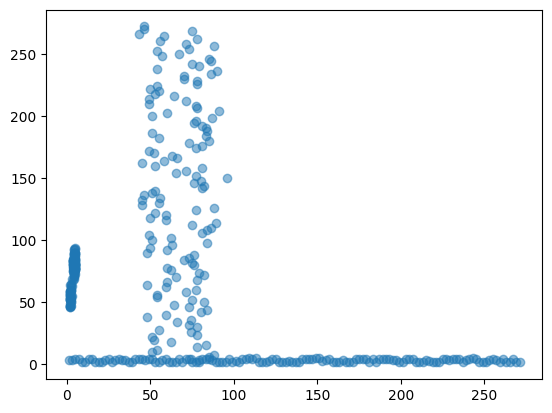

In [15]:
f = open("faithful.dat.txt",'r')
s=f.read()

l=s.split()
print(l)
df = pd.DataFrame()
l1=[]
l2=[]
for i in range(2,len(l),2):
    l1.append(float(l[i]))
for i in range(3,len(l),2):
    l2.append(float(l[i]))

df[l[0]] = l1
df[l[1]] = l2

plt.scatter(df[l[0]],df[l[1]],alpha=0.5)
df

In [12]:
gmm = GMMCustom(n_components=3, verbose=True,n_iter=100, k_means_initial=True)
gmm.fit(df)

C:\Users\Swarnarup\AppData\Local\Temp\ipykernel_6196\2350841017.py:117: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(np.sum([self.weights[k] * self._gaussian_pdf(X[i], self.means[k], self.covs[k]) for k in range(self.n_components)]))
GMM clustering:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Swarnarup\AppData\Local\Temp\ipykernel_6196\2350841017.py:91: RuntimeWarning: invalid value encountered in divide
  resp[i] /= np.sum(resp[i])
c:\Users\Swarnarup\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
GMM clustering: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


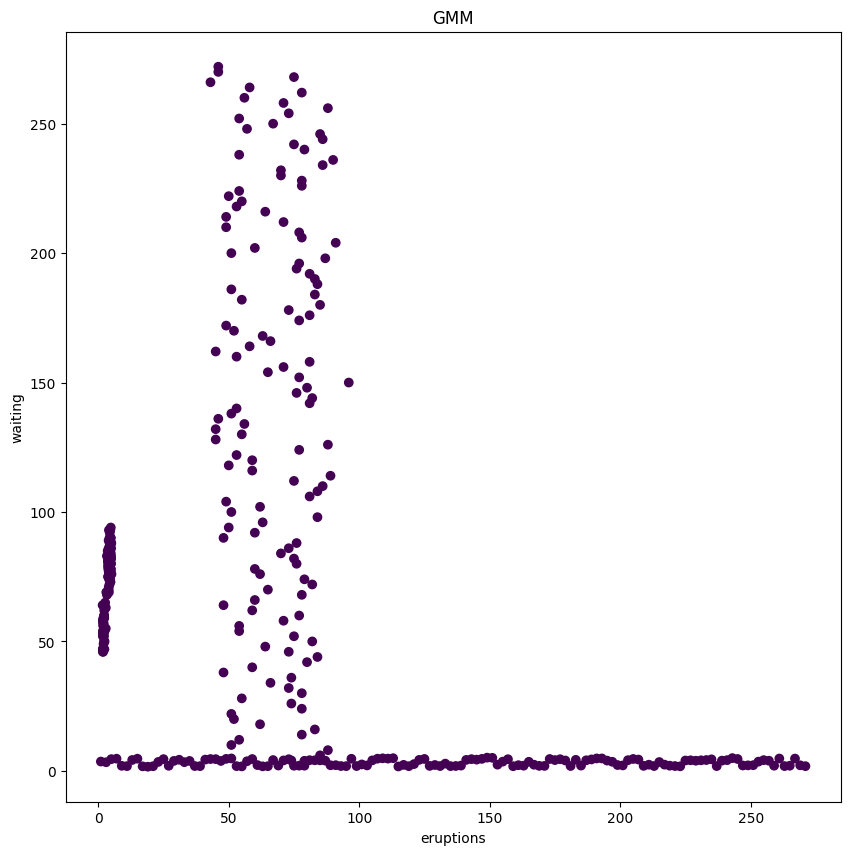

In [14]:
# plot data and gmm means
plt.figure(figsize=(10, 10))
plt.scatter(df['eruptions'], df['waiting'], c=gmm.resp.argmax(axis=1))
# fix scale of plot to above

# plot of history of mean with color showing iterations progression
for i in range(len(gmm.get_history('means'))):
    plt.scatter(gmm.get_history('means')[i][:, 0], gmm.get_history('means')[i][:, 1], c=['r', 'b','g'], alpha=(i+1)/len(gmm.get_history('means')))

plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.title('GMM')
plt.show()

In [10]:
a = gmm.get_history("means")

In [11]:
a

[array([[173.   ,   4.583],
        [ 57.   , 248.   ]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan],
        [nan, nan]]),
 array([[nan, nan]

In [4]:
# read data from .csv file multiple space separated
data = pd.read_csv('./faithful.csv', sep='\s+')

In [5]:
# apply gmm and plot clusters
gmm = GMMCustom(n_components=2, verbose=True, k_means_initial=False)
gmm.fit(data)


GMM clustering:   0%|          | 0/1000 [00:00<?, ?it/s]

Log likelihood converged at iteration 10


#### question 2 - part 1 and question 1
* Here red and blue colored points are means of bimodal gaussian distribution 
* and their alpha value shows the iteration of EM algorithm
* light colored are starting iterations and dark colored are final iterations

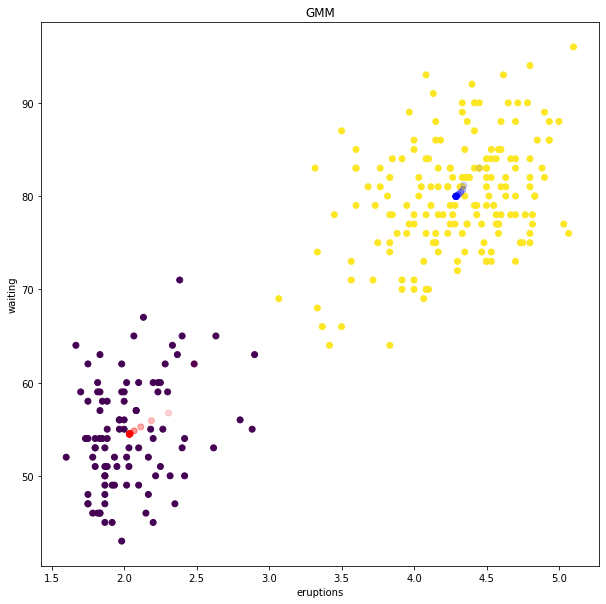

In [6]:
# plot data and gmm means
plt.figure(figsize=(10, 10))
plt.scatter(data['eruptions'], data['waiting'], c=gmm.resp.argmax(axis=1))
# fix scale of plot to above

# plot of history of mean with color showing iterations progression
for i in range(len(gmm.get_history('means'))):
    plt.scatter(gmm.get_history('means')[i][:, 0], gmm.get_history('means')[i][:, 1], c=['r', 'b'], alpha=(i+1)/len(gmm.get_history('means')))

plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.title('GMM')
plt.show()

#### question 2 - part 2
Run your program for 50 times with different initial parameter guesses. Show the
distribution of the total number of iterations needed for algorithm to converge.

In [7]:
# run 50 iterations
hist = []

for i in tqdm(range(50), desc="running 50 iterations"):
    gmm = GMMCustom(n_components=2, verbose=False)
    gmm.fit(data)
    hist.append(len(gmm.get_history('log_likelihood')))


running 50 iterations:   0%|          | 0/50 [00:00<?, ?it/s]

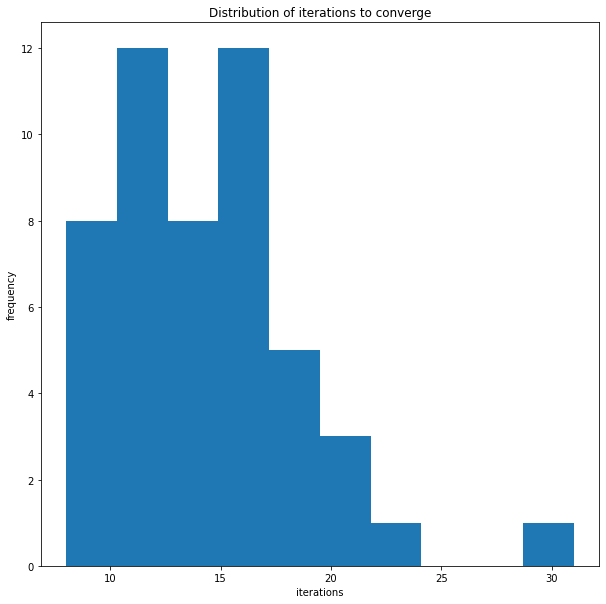

In [8]:
# plot histogram of iterations to converge
plt.figure(figsize=(10, 10))
plt.hist(hist)
plt.xlabel('iterations')
plt.ylabel('frequency')
plt.title('Distribution of iterations to converge')
plt.show()

#### question 3

In [9]:
gmm = GMMCustom(n_components=2, verbose=True, k_means_initial=True)
# initial parameters are calculated using k_means_initial=True
gmm.fit(data)

GMM clustering:   0%|          | 0/1000 [00:00<?, ?it/s]

Log likelihood converged at iteration 6


* when initialized with kMeans, the algorithm performs much better than random initialization
* it can be seen from values that kMeans took 6 iterations whereas random initialization took 10-20 iterations